In [1]:
import sys
sys.path.insert(0,'..')

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import torch
import re

from src.model_functions import model_factory

from analysis_utils import get_sparsity_for_model, get_sparsity_info, get_viz_data, get_nonzero_dicts

In [3]:
output_folder = "charts"
model_type = "bertbase" # bertl4

n_seeds = 5
par_idx = 0

folder = f"/share/home/lukash/pan16/{model_type}/cp"
experiment_name = "adverserial-diff_pruning_0.01-bert-base-uncased-64-2e-05-sp_pen1.25e-07-weighted_loss_prot-age-seed{}.pt"
# experiment_name = "adverserial-diff_pruning_0.01-bert-base-uncased-64-2e-05-sp_pen1.25e-07-cp_init-weighted_loss_prot-age-seed{}.pt"
# experiment_name = "modular-diff_pruning_0.01-bert-base-uncased-64-2e-05-sp_pen1.25e-07-weighted_loss_prot-gender_age-seed{}.pt"

# visualization params
model_cat = "adverserial" # adverserial, modular
prot_attr = "age"
savefigs = True

In [4]:
model_list = []
for seed in range(n_seeds):
    filepath = os.path.join(folder, experiment_name.format(seed))
    m = model_factory(filepath)
    model_list.append(m.get_diff_weights(idx=par_idx, as_module=False))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.La

In [5]:
base_nonzero_dict, layer_nonzero_dict, module_nonzero_dict, layer_module_nonzero_dict = get_nonzero_dicts(model_list)

In [6]:
model_dicts, model_layer_dicts, model_module_dicts = get_sparsity_info(folder, experiment_name, absolute=True, par_idx=par_idx)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.La

In [7]:
agg_fn = lambda k, dicts: sum([d[k][0][-1] for d in dicts]) / len(dicts)
base_dict = {k:agg_fn(k, model_dicts) for k in model_dicts[0].keys()}
layer_dict = {k:agg_fn(k, model_layer_dicts) for k in model_layer_dicts[0].keys()}
module_dict = {k:agg_fn(k, model_module_dicts) for k in model_module_dicts[0].keys()}

get_overlap_pct = lambda x, avg_sparsity: avg_sparsity / x[1:].sum()

module_overlap_pct_dict = {k:get_overlap_pct(v, module_dict[k]) for k,v in module_nonzero_dict.items()}
layer_overlap_pct_dict = {k:get_overlap_pct(v, layer_dict[k]) for k,v in layer_nonzero_dict.items()}
layer_module_overlap_pct_dict = {k:get_overlap_pct(v, base_dict[k]) for k,v in base_nonzero_dict.items()}

structured_overlap_pct_dict = {}
for k,v in layer_module_overlap_pct_dict.items():
    if k[:10]=="embeddings":
        n = k[11:]
        i = 0
    elif (x := re.match(r"^encoder\.layer\.\d+\.", k)):
        co = x.span()[1]
        n = k[co:]
        i = int(k[:co].split(".")[-2]) + 1
    try:
        structured_overlap_pct_dict[i][n] = v
    except KeyError:
        structured_overlap_pct_dict[i] = {n: v}

In [8]:
n_layers = len(layer_overlap_pct_dict) - 1
n_modules = len(module_overlap_pct_dict)
module_names = list(module_overlap_pct_dict.keys())

cmap = plt.get_cmap('Oranges')
color_fn = lambda x: abs(x)

width = 1
spacing = width / 4
y_coords = np.arange(n_layers)
y_coords_adj = np.concatenate([
    y_coords,
    [y_coords[-1] + width, y_coords[-1] + width*1.5]]
)
hline_positions = np.concatenate([
    (y_coords - width/2),
    [y_coords[-1] + width/2, y_coords_adj[-1] - width/2, y_coords_adj[-1] + width/2]
])
vline_positions = [0, width*n_modules, width*n_modules+spacing, width*(n_modules+1)+spacing]

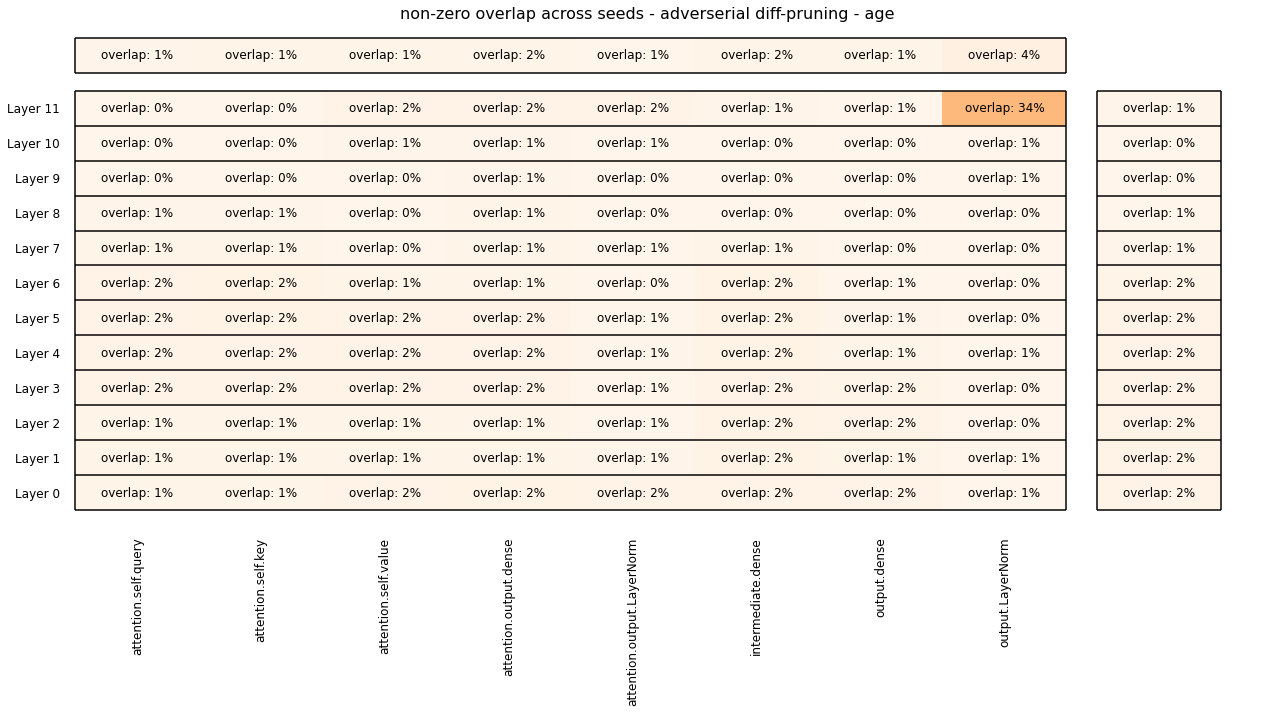

In [9]:
title_fontsize = 16
text_fontsize = 12
title = f"non-zero overlap across seeds - {model_cat} diff-pruning - {prot_attr}"
filename = f"nonzero_overlap_across_seeds_{model_cat}_{prot_attr}.png"

plt.figure(figsize=(18,10))
plt.barh(y_coords_adj, width/2, left=0-width/2, height=width, color="w")
start = 0
for m_name in module_names:
    overlap_pct = [x[m_name] for x in list(structured_overlap_pct_dict.values())[1:]]
    m_overlap_pct = module_overlap_pct_dict[m_name]
    # m_no_match, m_all_match = module_nonzero_pct_dict[m_name][0], module_nonzero_pct_dict[m_name][-1]
    color = [cmap(color_fn(a)) for a in overlap_pct]
    color.append("w")
    color.append(cmap(color_fn(m_overlap_pct)))
    plt.barh(y_coords_adj, width, height=width, left=start, color=color)
    for y, o in zip(y_coords, overlap_pct):
        plt.text(start+width/2, y, "overlap: {:.0%}".format(o), ha='center', va='center', color="k", fontsize=text_fontsize)
    plt.text(start+width/2, y_coords_adj[-1], "overlap: {:.0%}".format(m_overlap_pct), ha='center', va='center', color="k", fontsize=text_fontsize)
    start += width

plt.barh(y_coords, spacing, left=start, height=width, color="w")
start += spacing

overlap_pct = list(layer_overlap_pct_dict.values())[1:]
color = [cmap(color_fn(a)) for a in overlap_pct]
plt.barh(y_coords, width, left=start, height=width, color=color)
for y, o in zip(y_coords, overlap_pct):
    plt.text(start+width/2, y, "overlap: {:.0%}".format(o), ha='center', va='center', color="k", fontsize=text_fontsize)

for y in hline_positions:
    plt.hlines(y, 0, width*n_modules, colors="black")
for y in hline_positions[:-2]:
    plt.hlines(y, width*n_modules+spacing, width*(n_modules+1)+spacing, colors="black")

for x in vline_positions:
    plt.vlines(x, 0-width/2, y_coords[-1]+width/2, colors="black")
for x in vline_positions[:2]:
    plt.vlines(x, y_coords_adj[-1]-width/2, y_coords_adj[-1]+width/2, colors="black")

plt.xticks(np.arange(n_modules, step=width) + width/2, labels=module_names, rotation=90, fontsize=text_fontsize)
plt.yticks(y_coords, labels=[f"Layer {i}" for i in range(n_layers)], fontsize=text_fontsize)
plt.title(title, fontsize=title_fontsize, y=.98)
sns.despine(left=True, bottom=True, right=True)
plt.tick_params(axis="x", bottom=False, pad=0)
plt.tick_params(axis="y", left=False, pad=-50)

plt.tight_layout()
if savefigs:
    plt.savefig(os.path.join(output_folder, filename))
plt.show()

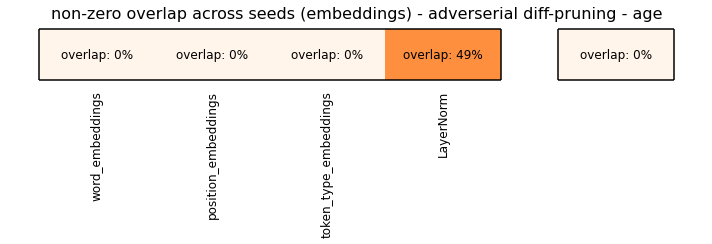

In [10]:
title = f"non-zero overlap across seeds (embeddings) - {model_cat} diff-pruning - {prot_attr}"
filename = f"nonzero_overlap_across_seeds_embedding_{model_cat}_{prot_attr}.png"

emb_dict = {k:get_overlap_pct(v, module_dict[k]) for k,v in layer_module_nonzero_dict[0].items()}
n_modules = len(emb_dict)

width = 1
spacing = width / 4
x_coords = np.arange(n_modules, step=width)
x_coords_adj = np.concatenate([x_coords, [x_coords[-1]+spacing+width/2, x_coords[-1]+width*1.5]])
overlap_pct = list(emb_dict.values())
l_overlap_pct = layer_overlap_pct_dict[0]
color = [cmap(color_fn(a)) for a in overlap_pct] + ["w", cmap(color_fn(l_overlap_pct))]
plt.figure(figsize=(10,3.5))
plt.bar(x_coords_adj, height=width, width=[width] * n_modules + [spacing, width], color=color)
for x, o in zip(x_coords, overlap_pct):
    plt.text(x, width/2, "overlap: {:.0%}".format(o), ha='center', va='center', color="k", fontsize=text_fontsize)
plt.text(x_coords_adj[-1], width/2, "overlap: {:.0%}".format(l_overlap_pct), ha='center', va='center', color="k", fontsize=text_fontsize)

x_coords_lines = [x_coords[0]-width/2, x_coords[-1]+width/2, x_coords[-1]+width/2+spacing*2, x_coords[-1]+width*1.5+spacing*2]
for y in [0, width]:
    plt.hlines(y, x_coords_lines[0], x_coords_lines[1], colors="black")
    plt.hlines(y, x_coords_lines[2], x_coords_lines[3], colors="black")
for x in x_coords_lines:
    plt.vlines(x, 0, width, colors="black")

plt.bar(0, height=-width, width=width, color="w")

plt.xticks(x_coords, labels=emb_dict.keys(), rotation=90, fontsize=text_fontsize)
plt.yticks([])
plt.title(title, fontsize=title_fontsize)
sns.despine(left=True, bottom=True, right=True)
plt.tick_params(axis="x", bottom=False, pad=-50)

plt.tight_layout()
if savefigs:
    plt.savefig(os.path.join(output_folder, filename))
plt.show()

### Analyze nonzero 

In [11]:
base_nonzero_dict, layer_nonzero_dict, module_nonzero_dict, layer_module_nonzero_dict = get_nonzero_dicts(model_list, only_nonzero=False)

In [12]:
get_nonzero_pct = lambda x: x[1:] / x[0]

module_nonzero_pct_dict = {k:get_nonzero_pct(v) for k,v in module_nonzero_dict.items()}
layer_nonzero_pct_dict = {k:get_nonzero_pct(v) for k,v in layer_nonzero_dict.items()}
layer_module_nonzero_pct_dict = {k1:{k2:get_nonzero_pct(v) for k2,v in d.items()} for k1,d in layer_module_nonzero_dict.items()}

In [13]:
n_layers = len(layer_nonzero_pct_dict) - 1
n_modules = len(module_nonzero_pct_dict)
module_names = list(module_nonzero_pct_dict.keys())

cmap = plt.get_cmap('Oranges')
color_fn = lambda x: abs(x)

width = 1
spacing = width / 4
y_coords = np.arange(n_layers)
y_coords_adj = np.concatenate([
    y_coords,
    [y_coords[-1] + width, y_coords[-1] + width*1.5]]
)
hline_positions = np.concatenate([
    (y_coords - width/2),
    [y_coords[-1] + width/2, y_coords_adj[-1] - width/2, y_coords_adj[-1] + width/2]
])
vline_positions = [0, width*n_modules, width*n_modules+spacing, width*(n_modules+1)+spacing]

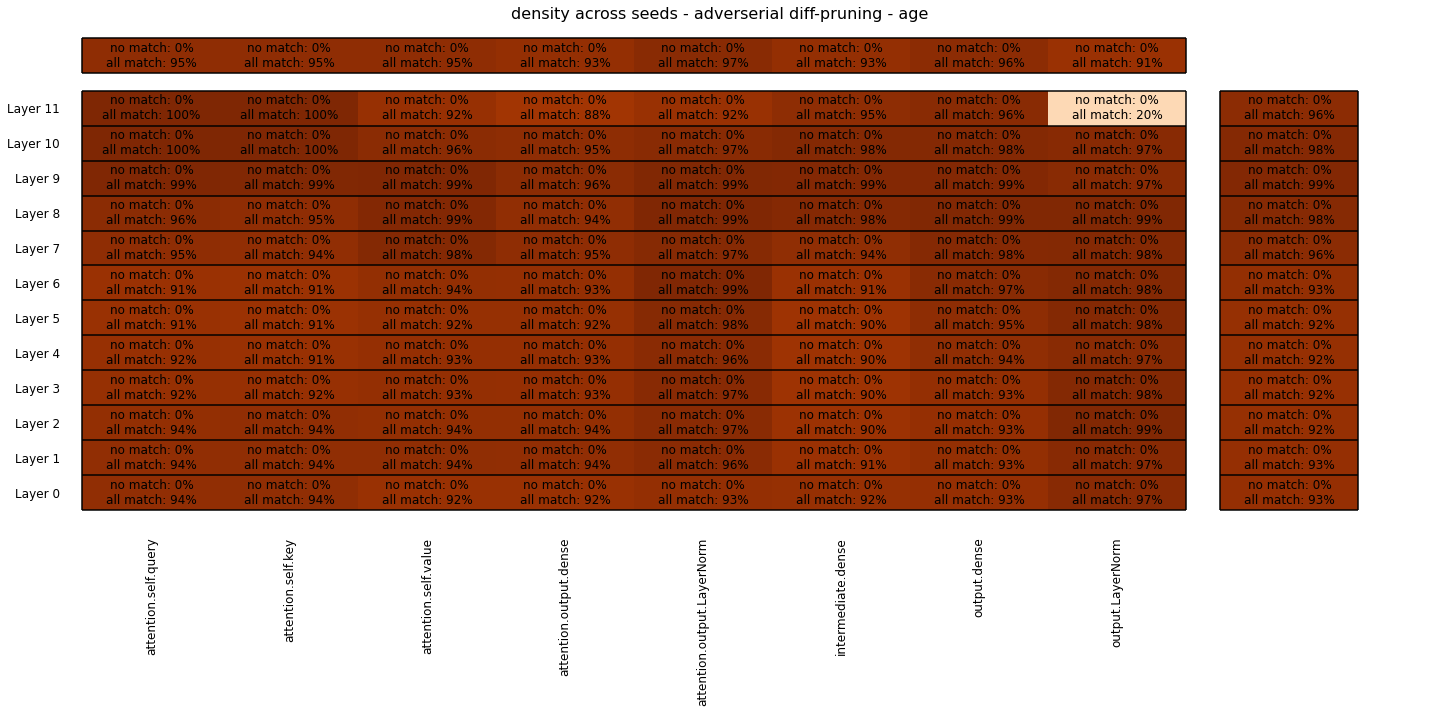

In [14]:
title_fontsize = 16
text_fontsize = 12
title = f"density across seeds - {model_cat} diff-pruning - {prot_attr}"
filename = f"density_across_seeds_{model_cat}_{prot_attr}.png"

plt.figure(figsize=(20,10))
plt.barh(y_coords_adj, width/2, left=0-width/2, height=width, color="w")
start = 0
for m_name in module_names:
    no_matches, all_matches = zip(*[x[m_name][[0,-1]] for x in list(layer_module_nonzero_pct_dict.values())[1:]])
    m_no_match, m_all_match = module_nonzero_pct_dict[m_name][0], module_nonzero_pct_dict[m_name][-1]
    color = [cmap(color_fn(a)) for a in all_matches]
    color.append("w")
    color.append(cmap(color_fn(m_all_match)))
    plt.barh(y_coords_adj, width, height=width, left=start, color=color)
    for y, a, e in zip(y_coords, no_matches, all_matches):
        plt.text(start+width/2, y, "no match: {:.0%}\nall match: {:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)
    plt.text(start+width/2, y_coords_adj[-1], "no match: {:.0%}\nall match: {:.0%}".format(m_no_match, m_all_match), ha='center', va='center', color="k", fontsize=text_fontsize)
    start += width

plt.barh(y_coords, spacing, left=start, height=width, color="w")
start += spacing

no_matches, all_matches = zip(*[x[[0,-1]] for x in list(layer_nonzero_pct_dict.values())[1:]])
color = [cmap(color_fn(a)) for a in all_matches]
plt.barh(y_coords, width, left=start, height=width, color=color)
for y, a, e in zip(y_coords, no_matches, all_matches):
    plt.text(start+width/2, y, "no match: {:.0%}\nall match: {:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)

for y in hline_positions:
    plt.hlines(y, 0, width*n_modules, colors="black")
for y in hline_positions[:-2]:
    plt.hlines(y, width*n_modules+spacing, width*(n_modules+1)+spacing, colors="black")

for x in vline_positions:
    plt.vlines(x, 0-width/2, y_coords[-1]+width/2, colors="black")
for x in vline_positions[:2]:
    plt.vlines(x, y_coords_adj[-1]-width/2, y_coords_adj[-1]+width/2, colors="black")

plt.xticks(np.arange(n_modules, step=width) + width/2, labels=module_names, rotation=90, fontsize=text_fontsize)
plt.yticks(y_coords, labels=[f"Layer {i}" for i in range(n_layers)], fontsize=text_fontsize)
plt.title(title, fontsize=title_fontsize, y=.98)
sns.despine(left=True, bottom=True, right=True)
plt.tick_params(axis="x", bottom=False, pad=0)
plt.tick_params(axis="y", left=False, pad=-50)

plt.tight_layout()
if savefigs:
    plt.savefig(os.path.join(output_folder, filename))
plt.show()

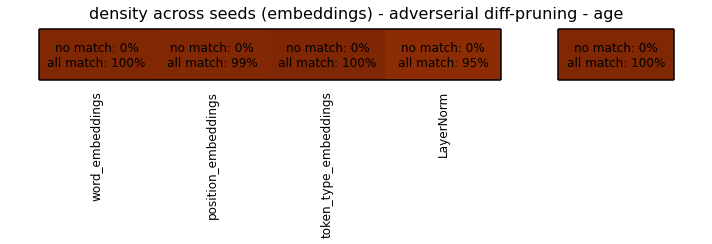

In [15]:
title = f"density across seeds (embeddings) - {model_cat} diff-pruning - {prot_attr}"
filename = f"density_across_seeds_embeddings_{model_cat}_{prot_attr}.png"

emb_dict = {k:get_nonzero_pct(v) for k,v in layer_module_nonzero_dict[0].items()}
n_modules = len(emb_dict)

width = 1
spacing = width / 4
x_coords = np.arange(n_modules, step=width)
x_coords_adj = np.concatenate([x_coords, [x_coords[-1]+spacing+width/2, x_coords[-1]+width*1.5]])
no_matches, all_matches= zip(*[x[[0,-1]] for x in emb_dict.values()])
l_no_match, l_all_match = layer_nonzero_pct_dict[0][[0,-1]]
color = [cmap(color_fn(a)) for a in all_matches] + ["w", cmap(color_fn(l_all_match))]
plt.figure(figsize=(10,3.5))
plt.bar(x_coords_adj, height=width, width=[width] * n_modules + [spacing, width], color=color)
for x, a, e in zip(x_coords, no_matches, all_matches):
    a, e = a.flatten()[0], e.flatten()[0]
    plt.text(x, width/2, "no match: {:.0%}\nall match: {:.0%}".format(a, e), ha='center', va='center', color="k", fontsize=text_fontsize)
plt.text(x_coords_adj[-1], width/2, "no match: {:.0%}\nall match: {:.0%}".format(l_no_match, l_all_match), ha='center', va='center', color="k", fontsize=text_fontsize)

x_coords_lines = [x_coords[0]-width/2, x_coords[-1]+width/2, x_coords[-1]+width/2+spacing*2, x_coords[-1]+width*1.5+spacing*2]
for y in [0, width]:
    plt.hlines(y, x_coords_lines[0], x_coords_lines[1], colors="black")
    plt.hlines(y, x_coords_lines[2], x_coords_lines[3], colors="black")
for x in x_coords_lines:
    plt.vlines(x, 0, width, colors="black")

plt.bar(0, height=-width, width=width, color="w")

plt.xticks(x_coords, labels=emb_dict.keys(), rotation=90, fontsize=text_fontsize)
plt.yticks([])
plt.title(title, fontsize=title_fontsize)
sns.despine(left=True, bottom=True, right=True)
plt.tick_params(axis="x", bottom=False, pad=-50)

plt.tight_layout()
if savefigs:
    plt.savefig(os.path.join(output_folder, filename))
plt.show()